# Project Description
You work at a startup that sells food products. You need to investigate user behavior for the
company's app.

First study the sales funnel. Find out how users reach the purchase stage. How many users
actually make it to this stage? How many get stuck at previous stages? Which stages in
particular?

Then look at the results of an A/A/B test. (Read on for more information about A/A/B testing.)
The designers would like to change the fonts for the entire app, but the managers are afraid the
users might find the new design intimidating. They decide to make a decision based on the
results of an A/A/B test.

The users are split into three groups: two control groups get the old fonts and one test group gets
the new ones. Find out which set of fonts produces better results.

Creating two A groups has certain advantages. We can make it a principle that we will only be
confident in the accuracy of our testing when the two control groups are similar. If there are
significant differences between the A groups, this can help us uncover factors that may be
distorting the results. Comparing control groups also tells us how much time and data we'll need
when running further tests.

You'll be using the same dataset for general analytics and for A/A/B analysis. In real projects,
experiments are constantly being conducted. Analysts study the quality of an app using general
data, without paying attention to whether users are participating in experiments.

# Initialization

Loading Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math 

Loading dataframe

In [2]:
logs = pd.read_csv("datasets/logs_exp_us.csv",sep='\t')

# Data preparation

## Reviewing data

Understanding the data

In [3]:
logs

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
logs.describe()

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


In [6]:
logs.duplicated().sum()

413

In [7]:
logs.isnull().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Data types looks okay. But the columns need too rename for easy to understand and analyse. Need to drop the duplicated row.

Fix: 
- Rename the columns in a way that's convenient for you
- Add a date and time column and a separate column for dates
- Drop the duplicated rows

## Fix data

Rename the columns

In [8]:
logs.columns = ['event_name','user_id','event_timestamp','exp_id']
logs.columns

Index(['event_name', 'user_id', 'event_timestamp', 'exp_id'], dtype='object')

Add a date and time column and a separate column for dates

In [9]:
# convert EventTimestamp column to datetime format
logs['datetime'] = pd.to_datetime(logs['event_timestamp'], unit='s')

# separate date and time into two columns
logs['date'] = logs['datetime'].dt.date
logs['time'] = logs['datetime'].dt.time

In [10]:
logs.head()

,event_name,user_id,event_timestamp,exp_id,datetime,date,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25,11:48:42


Drop duplicated row

In [11]:
logs = logs.drop_duplicates()

In [12]:
logs.duplicated().sum()

0

Create copy

In [13]:
logs_copy = logs.copy()

# Analysing data

Step 3. Study and check the data

- How many events are in the logs?
- How many users are in the logs?
- What's the average number of events per user?
- What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?
- Did you lose many events and users when excluding the older data?
- Make sure you have users from all three experimental groups.

- How many events are in the logs? 
- How many users are in the logs?
- What's the average number of events per user?

## Study the events and the users

Find:
- How many events are in the logs? 
- How many users are in the logs?
- What's the average number of events per user?

In [14]:
# Counting the number of events occur
num_events = len(logs_copy['event_name'])

# Counting the number of unique users
num_users = len(logs_copy['user_id'].unique())

# Calculating the average number of events per user
avg_events_per_user = len(logs_copy) / num_users

# Printing the results
print("Number of unique events:", num_events)
print("Number of unique users:", num_users)
print("Average number of events per user:", avg_events_per_user)

Number of unique events: 243713
Number of unique users: 7551
Average number of events per user: 32.27559263673685


What period of time does the data cover? Find the maximum and the minimum date. Plot a
histogram by date and time. Can you be sure that you have equally complete data for the entire
period? Older events could end up in some users' logs for technical reasons, and this could skew
the overall picture. Find the moment at which the data starts to be complete and ignore the
earlier section. What period does the data actually represent?

## Study the timeframe

Find max and min for date and timeframe

In [15]:
max_date = logs_copy['datetime'].max()
min_date = logs_copy['datetime'].min()

print ('Maximum Date :', max_date)
print ('Minimum Date :', min_date)

Maximum Date : 2019-08-07 21:15:17
Minimum Date : 2019-07-25 04:43:36


[]

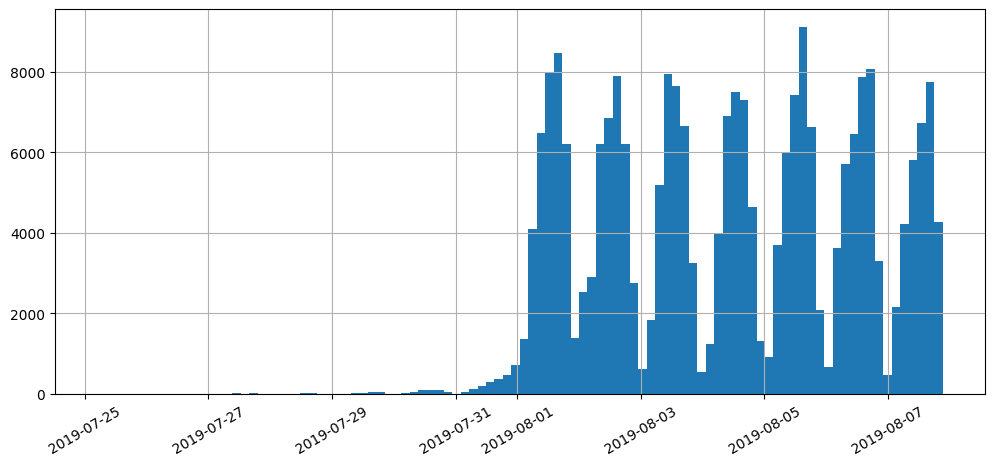

In [16]:
fig = plt.subplots(figsize =(12, 5))
plt.grid()
logs_copy['datetime'].hist(bins=100)
plt.xticks(rotation=30)
plt.plot()

**Observation**

From the histogram, app start to operate from 31 July. Lets see the fist date that complete all the events.

In [17]:
subset_df = logs_copy[["event_name", "date"]]
unique_counts = subset_df.groupby("date")["event_name"].nunique().reset_index()
unique_counts

,date,event_name
0,2019-07-25,4
1,2019-07-26,5
2,2019-07-27,5
3,2019-07-28,4
4,2019-07-29,4
5,2019-07-30,4
6,2019-07-31,5
7,2019-08-01,5
8,2019-08-02,5
9,2019-08-03,5


**Observation**

We can see that there's the day that events is not completed.The reason maybe there are try and error operation or any updated process happen in the app. we can see that 31 July, the events are completed and no updated occur after that. Therefore, 31 July is the start that. Now, 31 July is the started date until 7 August. From the histogram before, at 7 Aug,there is not completed 24 hours or 1 day. Therefore, the filtered data can we make is 7 days fully 24 hours.

Lets filtered data based on timeframe. The analysing timeframe are 1 week period for 24 hours.

[]

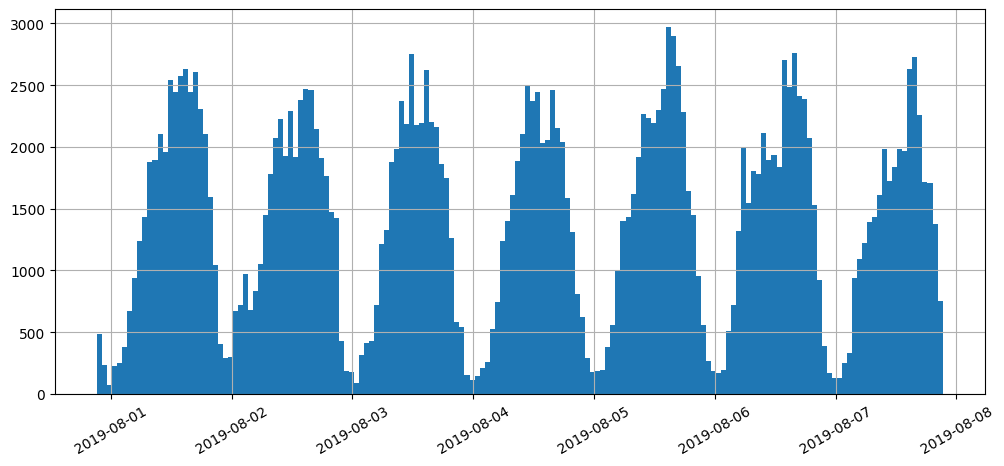

In [18]:
logs_filtered =  logs_copy[logs_copy['event_timestamp'] >= (1565212517-(7*24*60*60)+1)]

fig = plt.subplots(figsize =(12, 5))
plt.grid()
logs_filtered['datetime'].hist(bins=168)
plt.xticks(rotation=30)
plt.plot()

Lets review the losses from the original data.

In [19]:
# Counting the number of events occur
filt_num_events = len(logs_filtered['event_name'])
diff_num_events = num_events - filt_num_events
perc_diff_events= diff_num_events/num_events *100

# Counting the number of unique users
filt_num_users = len(logs_filtered['user_id'].unique())
diff_num_users = num_users - filt_num_users
perc_diff_users= diff_num_users/num_users *100

# Calculating the average number of events per user
filt_avg_events_per_user = len(logs_filtered) / filt_num_users
diff_avg_events_per_user = avg_events_per_user - filt_avg_events_per_user
perc_diff_events_per_user= diff_avg_events_per_user/avg_events_per_user *100

# Comparison
comparison = pd.DataFrame({'logs':['old' ,'new','difference','percentage_dif'],
                          'Number of events' : [num_events,filt_num_events,diff_num_events,perc_diff_events],
                          'Number of unique users':[num_users,filt_num_users,diff_num_users,perc_diff_users],
                          'Average number of events per user' : [avg_events_per_user,filt_avg_events_per_user,diff_avg_events_per_user,perc_diff_events_per_user]})
comparison

,logs,Number of events,Number of unique users,Average number of events per user
0,old,243713.000000,7551.000000,32.275593
1,new,241657.000000,7538.000000,32.058504
2,difference,2056.000000,13.000000,0.217089
3,percentage_dif,0.843615,0.172163,0.672611


**Observation**

Comparison from filtered and old data difference below 1%. The losses is low and minimal. Therefore, the filtered data is the data that will used for analyse

## Study the experimental groups

Make sure you have users from all three experimental groups.

In [20]:
user_per_groups = logs_filtered.groupby('exp_id').agg({'user_id':'nunique'}).reset_index()
user_per_groups

,exp_id,user_id
0,246,2484
1,247,2517
2,248,2537


**Observation**

The data show that all the three experimental groups have an average 2500 user_id.

# Analyse the event funnel

## Review the data

See what events are in the logs and their frequency of occurrence and sort them by frequency

In [21]:
freq_occ_events = (logs_filtered.groupby('event_name').agg({'user_id':'count'})).sort_values(by='user_id', ascending = False)
freq_occ_events 

,user_id
event_name,
MainScreenAppear,117853
OffersScreenAppear,46514
CartScreenAppear,42336
PaymentScreenSuccessful,33945
Tutorial,1009


Find the number of users who performed each of these actions and sort the events by the number
of users. Then, calculate the proportion of users who performed the action at least once.

In [22]:
freq_events = (logs_filtered.groupby('event_name').agg({'user_id':'nunique'})).sort_values(by='user_id', ascending = False).reset_index()
freq_events.columns = ['event_name','num_users']
freq_events

,event_name,num_users
0,MainScreenAppear,7423
1,OffersScreenAppear,4596
2,CartScreenAppear,3736
3,PaymentScreenSuccessful,3540
4,Tutorial,843


In [23]:
freq_events['ratio'] = freq_events['num_users']/len(logs_filtered['user_id'].unique())
freq_events

,event_name,num_users,ratio
0,MainScreenAppear,7423,0.984744
1,OffersScreenAppear,4596,0.609711
2,CartScreenAppear,3736,0.495622
3,PaymentScreenSuccessful,3540,0.469621
4,Tutorial,843,0.111833


**Observation**

From the table above, the order of action are like this: 
1) MainScreenAppear	
2) OffersScreenAppear	
3) CartScreenAppear
4) PaymentScreenSuccessful
5) Tutorial

However, the tutorial event seems weirdly at the last because tutorial must be the first. Therefore, the event orders like this  
1) Tutorial
2) MainScreenAppear	
3) OffersScreenAppear	
4) CartScreenAppear
5) PaymentScreenSuccessful

The reason why tutorial ratio is less than the second order are because this order are not in a single sequence. Then, tutorial don't need to take  into account when calculating the funnel.


## Analyse sequence of events 

Use the event funnel to find the share of users that proceed from each stage to the next. (For
instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the
number of users at stage A and the ratio of users at stage C to the number at stage B.)

In [24]:
num_users

7551

In [25]:
# remove tutorial 
freq_events.drop([4], axis=0, inplace=True)
# Calculate conversion rates for each step of the funnel
num_users = freq_events['num_users'].tolist()
conversion_rates = [1.0]
for i in range(1, len(num_users)):
    rate = num_users[i] / num_users[i-1]
    conversion_rates.append(round(rate, 2))

# Add conversion rates to DataFrame
freq_events['conversion_rate'] = conversion_rates
freq_events

,event_name,num_users,ratio,conversion_rate
0,MainScreenAppear,7423,0.984744,1.00
1,OffersScreenAppear,4596,0.609711,0.62
2,CartScreenAppear,3736,0.495622,0.81
3,PaymentScreenSuccessful,3540,0.469621,0.95


**Observation**

We can see that OffersScreenAppear stage lost the most user. The reason maybe most of the users just browsing the apps and only 62 percent that want to buy from the apps. Then, only 20 percent losses go to the cart and 5 percent loses that cancel the payment.  

## User go through all the events

Lets find share of users that make the entire journey from their first event to payment.

In [26]:
conversion_rates = freq_events['ratio'].tolist()
overall_conversion_rate = round(conversion_rates[0] * conversion_rates[1] * conversion_rates[2] * conversion_rates[3], 3)

# Display overall conversion rate
print(f"The share of users who make the entire journey from their first event to payment is {overall_conversion_rate}.")

The share of users who make the entire journey from their first event to payment is 0.14.


#  Study the results of the experiment

## User for each groups

In [27]:
user_per_groups

,exp_id,user_id
0,246,2484
1,247,2517
2,248,2537


## Find statistical significant (246 & 247)

**We have two control groups in the A/A test, where we check our mechanisms and calculations.
See if there is a statistically significant difference between samples 246 and 247.**

**Select the most popular event. In each of the control groups, find the number of users who
performed this action. Find their share. Check whether the difference between the groups is
statistically significant. Repeat the procedure for all other events (it will save time if you create a
special function for this test). Can you confirm that the groups were split properly?**

Lets review the user id for each event and groups

In [28]:
user_per_event_groups_index = logs_filtered.groupby(['event_name','exp_id']).agg({'user_id':'nunique'})
user_per_event_groups_index

user_id
event_name              exp_id         
CartScreenAppear        246        1266
                        247        1239
                        248        1231
MainScreenAppear        246        2450
                        247        2479
                        248        2494
OffersScreenAppear      246        1542
                        247        1523
                        248        1531
PaymentScreenSuccessful 246        1200
                        247        1158
                        248        1182
Tutorial                246         278
                        247         284
                        248         281

In [29]:
user_per_event_groups = user_per_event_groups_index.reset_index()

## A/A test between 246 and 247

We have two control groups in the A/A test, where we check our mechanisms and calculations. Lets see if there is a statistically significant difference between samples 246 and 247.

In [30]:
alpha = .01 # significance level

trials_246 = user_per_groups.loc[user_per_groups['exp_id'] == 246, 'user_id'].iloc[0]
trials_247 = user_per_groups.loc[user_per_groups['exp_id'] == 247, 'user_id'].iloc[0]
purchase_246 = user_per_event_groups.loc[((user_per_event_groups['exp_id'] == 246)&(user_per_event_groups['event_name'] == 'MainScreenAppear')), 'user_id'].iloc[0]
purchase_247 = user_per_event_groups.loc[((user_per_event_groups['exp_id'] == 247)&(user_per_event_groups['event_name'] == 'MainScreenAppear')), 'user_id'].iloc[0]

purchases = np.array([purchase_246, purchase_247])
trials = np.array([trials_246, trials_247])

p1 = purchases[0]/trials[0]
p2 = purchases[1]/trials[1]

p_combined = (purchases[0] + purchases[1]) / (trials[0] + trials[1])
difference = p1 - p2 

z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the proportions")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the proportions different")

p-value:  0.6756217702005545
Failed to reject the null hypothesis: there is no reason to consider the proportions different


**Observation**

The sample group for 246 and 247 have the same proportion. Therefore, its failed to reject the null hypothesis where's there is no reason to consider the proportions different

## Statistical significant for all events

In [31]:
def stat_sign (data1,data2,event,contrl1,contrl2,alpha):
    order1 = data2.loc[((data2['exp_id'] == contrl1)&(data2['event_name'] == event)), 'user_id'].iloc[0]
    order2 = data2.loc[((data2['exp_id'] == contrl2)&(data2['event_name'] == event)), 'user_id'].iloc[0]
    
    user1 = data1.loc[data1['exp_id'] == contrl1, 'user_id'].iloc[0]
    user2 = data1.loc[data1['exp_id'] == contrl2, 'user_id'].iloc[0]
    
    purchase1 = order1/user1
    purchase2 = order2/user2
    trials1 = user1
    trials2 = user2

    print (f'Purchases in {event} at control group {contrl1} is {purchase1}')
    print (f'Purchases in {event} at control group {contrl2} is {purchase2}')
    
    p1 = order1/trials1
    p2 = order2/trials2

    p_combined1 = (order1 + order2) / (trials1 + trials2)
    difference1 = p1 - p2 
    
    z_value1 = difference1 / math.sqrt(p_combined1 * (1 - p_combined1) * (1/trials1 + 1/trials2))
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value1))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions different")

In [32]:
events = user_per_event_groups['event_name'].unique()
for event in list(events):
    stat_sign (user_per_groups,user_per_event_groups,event,246,247,0.05)
    print()

Purchases in CartScreenAppear at control group 246 is 0.5096618357487923
Purchases in CartScreenAppear at control group 247 is 0.4922526817640048
p-value:  0.2182812140633792
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in MainScreenAppear at control group 246 is 0.9863123993558777
Purchases in MainScreenAppear at control group 247 is 0.9849026618990863
p-value:  0.6756217702005545
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in OffersScreenAppear at control group 246 is 0.6207729468599034
Purchases in OffersScreenAppear at control group 247 is 0.6050854191497815
p-value:  0.2548030321293888
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in PaymentScreenSuccessful at control group 246 is 0.4830917874396135
Purchases in PaymentScreenSuccessful at control group 247 is 0.4600715137067938
p-value:  0.10298394982

**Observation**

We can see the 'MainScreenAppear' events is the most popular events for groups 246 and 247. Both groups reach 98% attendance in this events. The sample group for 246 and 247 have the same proportion and its failed to reject the null hypothesis

## Statistical significant for test groups

In [33]:
user_per_event_groups_index

user_id
event_name              exp_id         
CartScreenAppear        246        1266
                        247        1239
                        248        1231
MainScreenAppear        246        2450
                        247        2479
                        248        2494
OffersScreenAppear      246        1542
                        247        1523
                        248        1531
PaymentScreenSuccessful 246        1200
                        247        1158
                        248        1182
Tutorial                246         278
                        247         284
                        248         281

In [34]:
user_per_groups

,exp_id,user_id
0,246,2484
1,247,2517
2,248,2537


In [35]:
user_per_event_groups

,event_name,exp_id,user_id
0,CartScreenAppear,246,1266
1,CartScreenAppear,247,1239
2,CartScreenAppear,248,1231
3,MainScreenAppear,246,2450
4,MainScreenAppear,247,2479
5,MainScreenAppear,248,2494
6,OffersScreenAppear,246,1542
7,OffersScreenAppear,247,1523
8,OffersScreenAppear,248,1531
9,PaymentScreenSuccessful,246,1200


In [36]:
for event in list(events):
    stat_sign (user_per_groups,user_per_event_groups,event,246,248,0.05)
    print()

Purchases in CartScreenAppear at control group 246 is 0.5096618357487923
Purchases in CartScreenAppear at control group 248 is 0.48521876231769806
p-value:  0.08328412977507749
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in MainScreenAppear at control group 246 is 0.9863123993558777
Purchases in MainScreenAppear at control group 248 is 0.9830508474576272
p-value:  0.34705881021236484
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in OffersScreenAppear at control group 246 is 0.6207729468599034
Purchases in OffersScreenAppear at control group 248 is 0.6034686637761135
p-value:  0.20836205402738917
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in PaymentScreenSuccessful at control group 246 is 0.4830917874396135
Purchases in PaymentScreenSuccessful at control group 248 is 0.4659046117461569
p-value:  0.2226935

In [37]:
for event in list(events):
    stat_sign (user_per_groups,user_per_event_groups,event,247,248,0.05)
    print()

Purchases in CartScreenAppear at control group 247 is 0.4922526817640048
Purchases in CartScreenAppear at control group 248 is 0.48521876231769806
p-value:  0.6169517476996997
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in MainScreenAppear at control group 247 is 0.9849026618990863
Purchases in MainScreenAppear at control group 248 is 0.9830508474576272
p-value:  0.6001661582453706
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in OffersScreenAppear at control group 247 is 0.6050854191497815
Purchases in OffersScreenAppear at control group 248 is 0.6034686637761135
p-value:  0.9064474651756644
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in PaymentScreenSuccessful at control group 247 is 0.4600715137067938
Purchases in PaymentScreenSuccessful at control group 248 is 0.4659046117461569
p-value:  0.6775413642

**Conclusion** 

The p-value for sample 247-248 is higher that sample 246-248. However, it still failed to reject the null hypothesis for both sample 246 and 247 with sample 248. There is no reason to consider the proportions different.

## Statistical significant with different significant level

Set the significant level to 0.1

In [38]:
for event in list(events):
    stat_sign (user_per_groups,user_per_event_groups,event,246,248,0.1)
    print()

Purchases in CartScreenAppear at control group 246 is 0.5096618357487923
Purchases in CartScreenAppear at control group 248 is 0.48521876231769806
p-value:  0.08328412977507749
Rejecting the null hypothesis: there is a significant difference between the proportions

Purchases in MainScreenAppear at control group 246 is 0.9863123993558777
Purchases in MainScreenAppear at control group 248 is 0.9830508474576272
p-value:  0.34705881021236484
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in OffersScreenAppear at control group 246 is 0.6207729468599034
Purchases in OffersScreenAppear at control group 248 is 0.6034686637761135
p-value:  0.20836205402738917
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in PaymentScreenSuccessful at control group 246 is 0.4830917874396135
Purchases in PaymentScreenSuccessful at control group 248 is 0.4659046117461569
p-value:  0.2226935899468

In [39]:
for event in list(events):
    stat_sign (user_per_groups,user_per_event_groups,event,247,248,0.1)
    print()

Purchases in CartScreenAppear at control group 247 is 0.4922526817640048
Purchases in CartScreenAppear at control group 248 is 0.48521876231769806
p-value:  0.6169517476996997
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in MainScreenAppear at control group 247 is 0.9849026618990863
Purchases in MainScreenAppear at control group 248 is 0.9830508474576272
p-value:  0.6001661582453706
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in OffersScreenAppear at control group 247 is 0.6050854191497815
Purchases in OffersScreenAppear at control group 248 is 0.6034686637761135
p-value:  0.9064474651756644
Failed to reject the null hypothesis: there is no reason to consider the proportions different

Purchases in PaymentScreenSuccessful at control group 247 is 0.4600715137067938
Purchases in PaymentScreenSuccessful at control group 248 is 0.4659046117461569
p-value:  0.6775413642

**Conclusion**

Before, we have test 10 tests to find the statistical different with significant level 0.05 and all are failed to reject the hypothesis. Now, the new 10 tests with the significant level is 0.1 and show 1 false. By increasing the significant level, it more likely to reject the null hypothesis and conclude that there is a significant difference. It also means that 'CartScreenAppear' events for sample 246-248 have a 10% difference. For this project, significant level 0.1 is the best choice if we want to see clearly if any chance have the risk in the change happen between the control data and the experiment data.

# Overall Conclusion

**Summary**

sales funnel
- the is not a single sequence. It can be assumed that the 'Totorial' event can be skip.
- the 'OffersScreenAppear' event loss 38% participant from the first event. This part may can be improvise to increase the percentage.
- users who make the entire journey from their first event to payment is only 14%. Increasing this percentage can helps to increase the change for the user to buy in the apps.


A/A test
- Comparison between group sample 246 and 247
- Purchasing in group 246 is slightly higher than group 247
- However there are no statistical significant difference between both sample if we set the significance level 0.05 which mean the difference is below 5%.

A/B test
- Comparison between group sample 246 and 247 and comparison between group sample 246 and 247.
- All the purchasing(participant) for all event show 246 and 247 is better that 248 but only the 'PaymentScreenSuccessful' event got slighly higher. 
- However, there have statistical significant difference between both sample if we set the significance level 0.1 which  10% have the diffencence between both group.

**Conclusion**

From the A/A/B tests, the old font show the slighly better result compare to the new fonts for the time period 1 week. However, user might need a time to change and compatible with the new fonts. To lower the risk for the next time period. its better to stick with the old fonts. A/A/B test should be stop here to lower the chance to get worse consequences. 
